In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

2026-01-31 11:42:26.441318: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-31 11:42:26.504003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-31 11:42:27.989587: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
class Inception(tf.keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.p1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same', activation='relu')
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same', activation='relu')
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')
    @tf.function
    def call(self, x):
        p1 = self.p1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        #return tf.keras.layers.concatenate()([p1, p2, p3, p4])
        return tf.keras.layers.concatenate([p1,p2,p3,p4], axis=3)


In [3]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [4]:
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [5]:
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [6]:
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [7]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])

# “net”必须是一个将被传递给“d2l.train_ch6（）”的函数。
# 为了利用我们现有的CPU/GPU设备，这样模型构建/编译需要在“strategy.scope()”
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [8]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

I0000 00:00:1769830949.288539   44393 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13578 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:08.0, compute capability: 7.5
2026-01-31 11:42:29.582754: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykernel_launcher.runfiles/cuda_nvdisasm
  ipykernel_launcher.runfiles/nvidia_nvshmem
  ipykern/cuda_nvcc
  ipykern/cuda_nvdisasm
  ipykern/nvidia_nvshmem
  
  /usr/local/cuda
  /opt/cuda
  /home/ubuntu/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/ubuntu/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../n

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


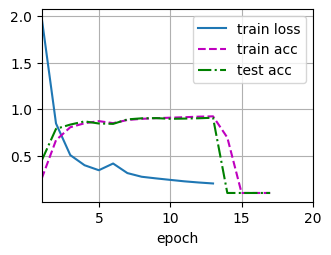

In [9]:
lr, num_epochs, batch_size = 0.1, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
glnet = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
glnet.export("/home/ubuntu/work/data/gnet/saved_model")

In [ ]:
print(glnet.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (128, 24, 24, 64)      │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (128, 12, 12, 192)     │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (128, 6, 6, 480)       │       552,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (128, 3, 3, 832)       │     2,809,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (128, 1024)            │     2,487,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 10)              │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,977,532 (22.80 MB)

 Trainable params: 5,977,530 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
